In [1]:
#Dependancies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
import re
import scipy.stats as stats
import seaborn as sns

sns.set(rc={'figure.figsize':(17,17)})


In [2]:
# Import downloaded CSV as "starter data"
wines_csv = "winemag-data-130k-v2.csv"
wine_df = pd.read_csv(wines_csv)
wine_df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
# Lets take a look at what we are starting with
print([wine_df.count()])

[Unnamed: 0               129971
country                  129908
description              129971
designation               92506
points                   129971
price                    120975
province                 129908
region_1                 108724
region_2                  50511
taster_name              103727
taster_twitter_handle     98758
title                    129971
variety                  129970
winery                   129971
dtype: int64]


In [4]:
# Drop unneeded columns, drop any records NaN and see what we are left with
wine_df2 = wine_df.drop(['Unnamed: 0' ,'description','designation','region_1', 'region_2', 
                         'taster_name', 'taster_twitter_handle'], axis=1).dropna()
print(wine_df2.count())
wine_df2.head()

country     120915
points      120915
price       120915
province    120915
title       120915
variety     120915
winery      120915
dtype: int64


,country,points,price,province,title,variety,winery
1,Portugal,87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem


In [5]:
#Make copy of refined data to start working with (CWD = Clean Working Data)
CWD = wine_df2.copy()
#calculate new wine metric using price/adjusted rating point are from 80-100pts and add to CWD
CWD['new_wine_metric'] = CWD['price']/(CWD['points']-79)
CWD

,country,points,price,province,title,variety,winery,new_wine_metric
1,Portugal,87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,1.875000
2,US,87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,1.750000
3,US,87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,1.625000
4,US,87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,8.125000
5,Spain,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,1.875000
...,...,...,...,...,...,...,...,...
129966,Germany,90,28.0,Mosel,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),2.545455
129967,US,90,75.0,Oregon,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,6.818182
129968,France,90,30.0,Alsace,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2.727273
129969,France,90,32.0,Alsace,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,2.909091


In [6]:
#Basic Data
print('Basic analysis of price and point data:')
cal_count = CWD.loc[CWD['province'] == 'California']['new_wine_metric'].count()
noncal_count = CWD.loc[CWD['province'] != 'California']['new_wine_metric'].count()
print(f'Of the {len(CWD)} records, {cal_count} were reviews of Californian wines while {noncal_count} were not.')
cal_price = CWD.loc[CWD['province'] == 'California']['price']
noncal_price = CWD.loc[CWD['province'] != 'California']['price']
print(f'Californian wine has a price range of ${cal_price.min()} to ${cal_price.max()} with an avg. of ${cal_price.mean()}')
print(f'Non Californian wine has a price range of ${noncal_price.min()} to ${noncal_price.max()} with an avg. of ${noncal_price.mean()}')
cal_pts = CWD.loc[CWD['province'] == 'California']['points']
noncal_pts = CWD.loc[CWD['province'] != 'California']['points']
print(f'California wine is typically rated at about {cal_pts.mean()}pts, while Non Californian wine is rated at {noncal_pts.mean()}pts')
cal_nwm = CWD.loc[CWD['province'] == 'California']['new_wine_metric']
noncal_nwm = CWD.loc[CWD['province'] != 'California']['new_wine_metric']
print(f'California NWM = {cal_nwm.mean()}, NonCalifornia NWM = {noncal_nwm.mean()}')

Basic analysis of price and point data:
Of the 120915 records, 36104 were reviews of Californian wines while 84811 were not.
Californian wine has a price range of $4.0 to $2013.0 with an avg. of $39.04104808331487
Non Californian wine has a price range of $4.0 to $3300.0 with an avg. of $33.80552051031116
California wine is typically rated at about 88.6295147352094pts, while Non Californian wine is rated at 88.33327044840881pts
California NWM = 4.207393880952622, NonCalifornia NWM = 3.492135739366323


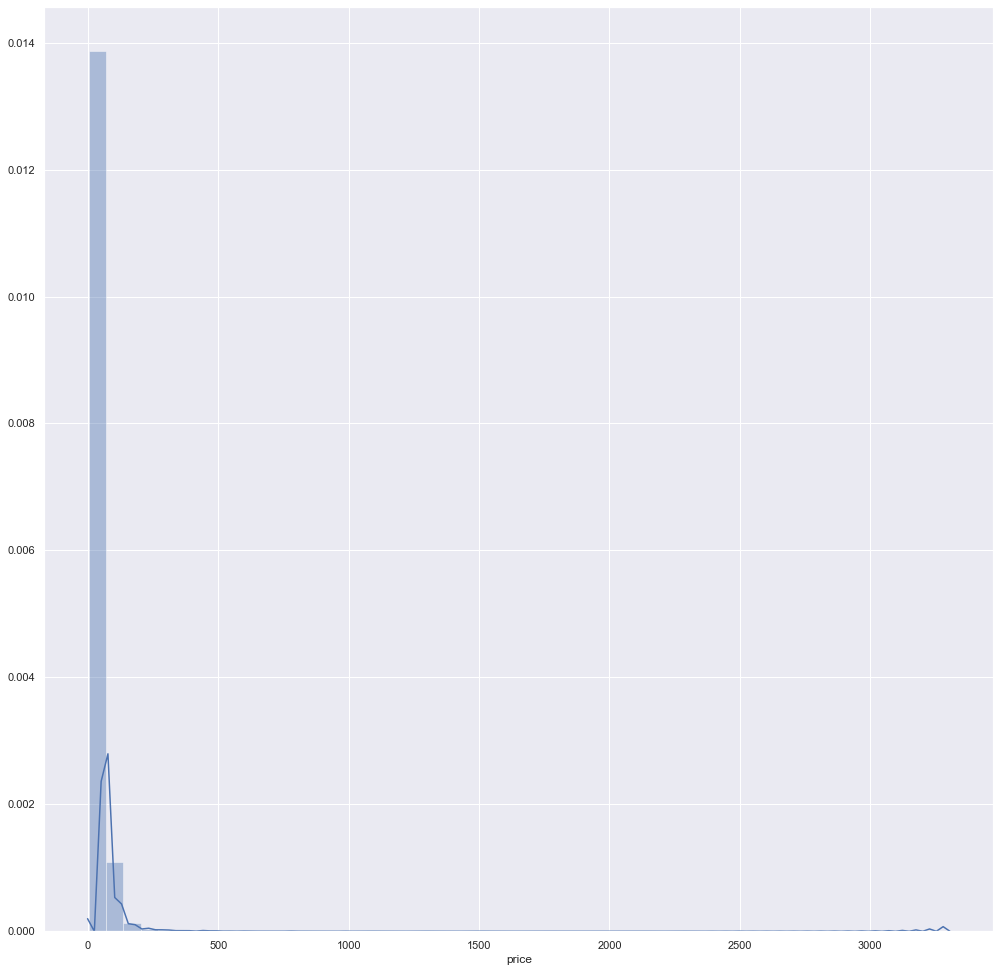

In [7]:
sns.distplot(CWD.price)

In [8]:
total_wine_count = len(CWD)

# look at IQR for price
cwd_price_iqr = CWD['price']
cwd_quartiles = round(cwd_price_iqr.quantile([.25,.5,.75]),2)
cwd_lowerq = round(cwd_quartiles[0.25],2)
cwd_upperq = round(cwd_quartiles[0.75],2)
cwd_iqr = round(cwd_upperq-cwd_lowerq,2)

print('Total IQR price Data:')
print(f"The lower quartile of price for All Wines is : {cwd_lowerq}")
print(f"The upper quartile of price for All Wines is: {cwd_upperq}")
print(f"The interquartile range of pricee for All Wines is: {cwd_iqr}")
print(f"The the median of price for All Wines is: {cwd_quartiles[0.5]} ")

cwd_lower_bound = round(cwd_lowerq - (1.5*cwd_iqr),2)
cwd_upper_bound = round(cwd_upperq + (1.5*cwd_iqr),2)

# print(f"Values below {cal_lower_bound} could be outliers.")

print(f"Values above {cwd_upper_bound} could be outliers.")
cwd_upr_otlr_count = CWD['price'][CWD['price'] > [cwd_upper_bound][0]].count()
cwd_otlr_pct = (cwd_upr_otlr_count/total_wine_count)*100
print(f'Of the {total_wine_count} Californian wines, There are {cwd_upr_otlr_count} above the upper bounds or {cwd_otlr_pct.round(2)}%')


Total IQR price Data:
The lower quartile of price for All Wines is : 17.0
The upper quartile of price for All Wines is: 42.0
The interquartile range of pricee for All Wines is: 25.0
The the median of price for All Wines is: 25.0 
Values above 79.5 could be outliers.
Of the 120915 Californian wines, There are 7241 above the upper bounds or 5.99%


In [9]:
adj_cwd = CWD.loc[CWD['price'] < [cwd_upper_bound][0]]
adj_cwd

,country,points,price,province,title,variety,winery,new_wine_metric
1,Portugal,87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,1.875000
2,US,87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,1.750000
3,US,87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,1.625000
4,US,87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,8.125000
5,Spain,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,1.875000
...,...,...,...,...,...,...,...,...
129966,Germany,90,28.0,Mosel,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),2.545455
129967,US,90,75.0,Oregon,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,6.818182
129968,France,90,30.0,Alsace,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2.727273
129969,France,90,32.0,Alsace,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,2.909091


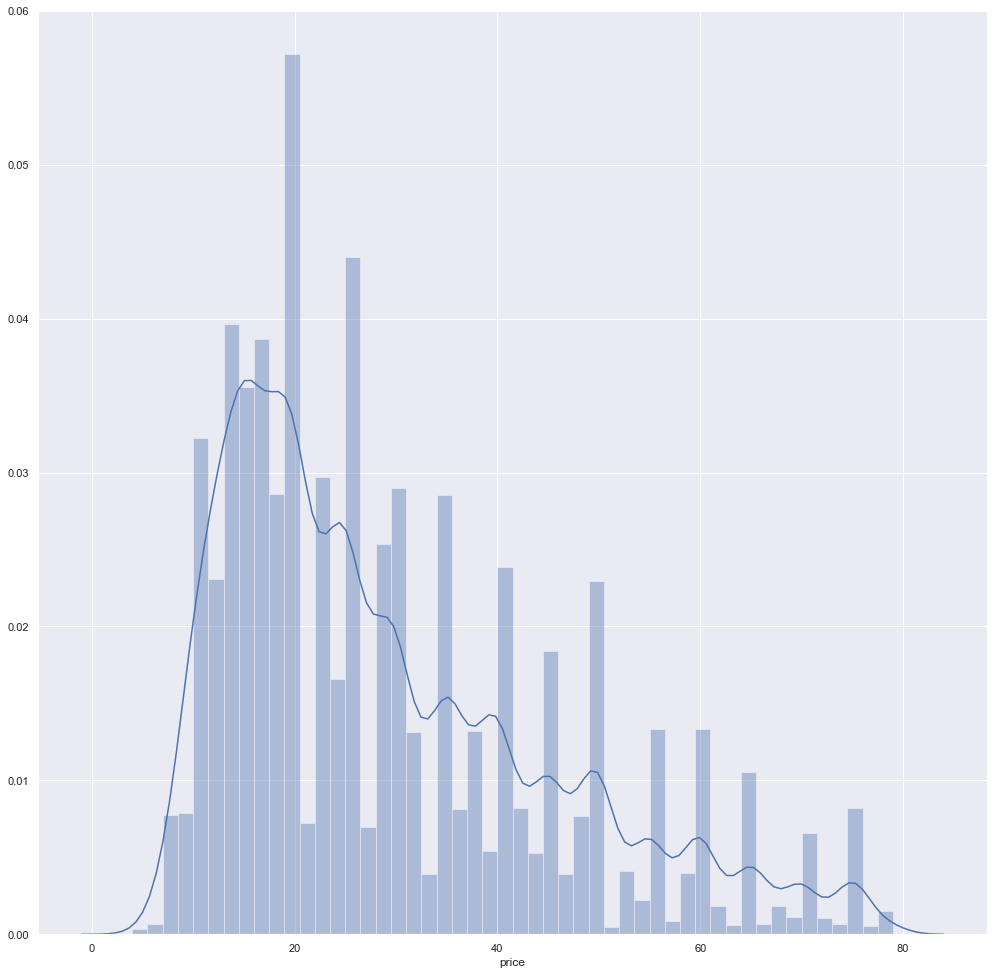

In [10]:
sns.distplot(adj_cwd.price)

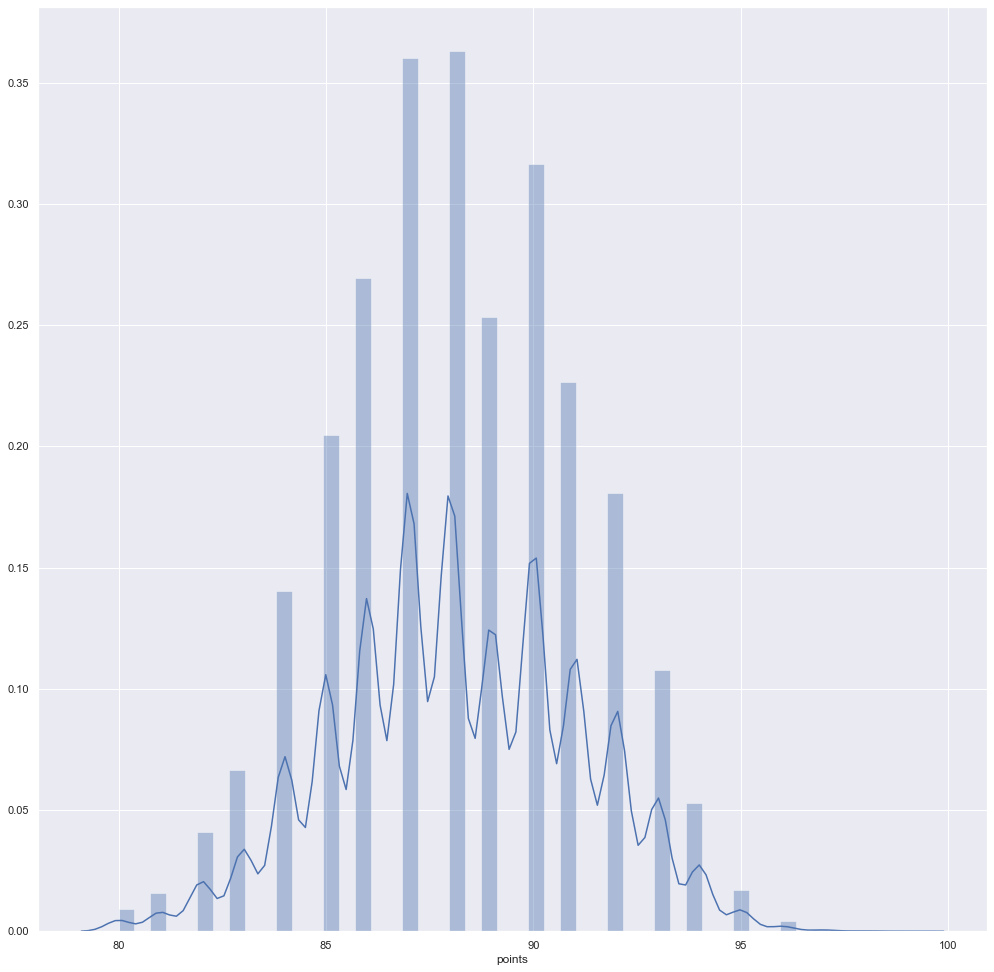

In [11]:
sns.distplot(adj_cwd.points)

The total number of unique countries is 42
[country
US              51568
France          16095
Italy           15386
Spain            6233
Portugal         4696
Chile            4300
Argentina        3600
Austria          2728
Australia        2108
Germany          1947
New Zealand      1350
South Africa     1260
Israel            476
Greece            461
Canada            239
Bulgaria          140
Hungary           137
Romania           118
Uruguay           107
Turkey             89
Name: points, dtype: int64]


Text(0.5, 1.0, 'Top 15 countries by count of review')

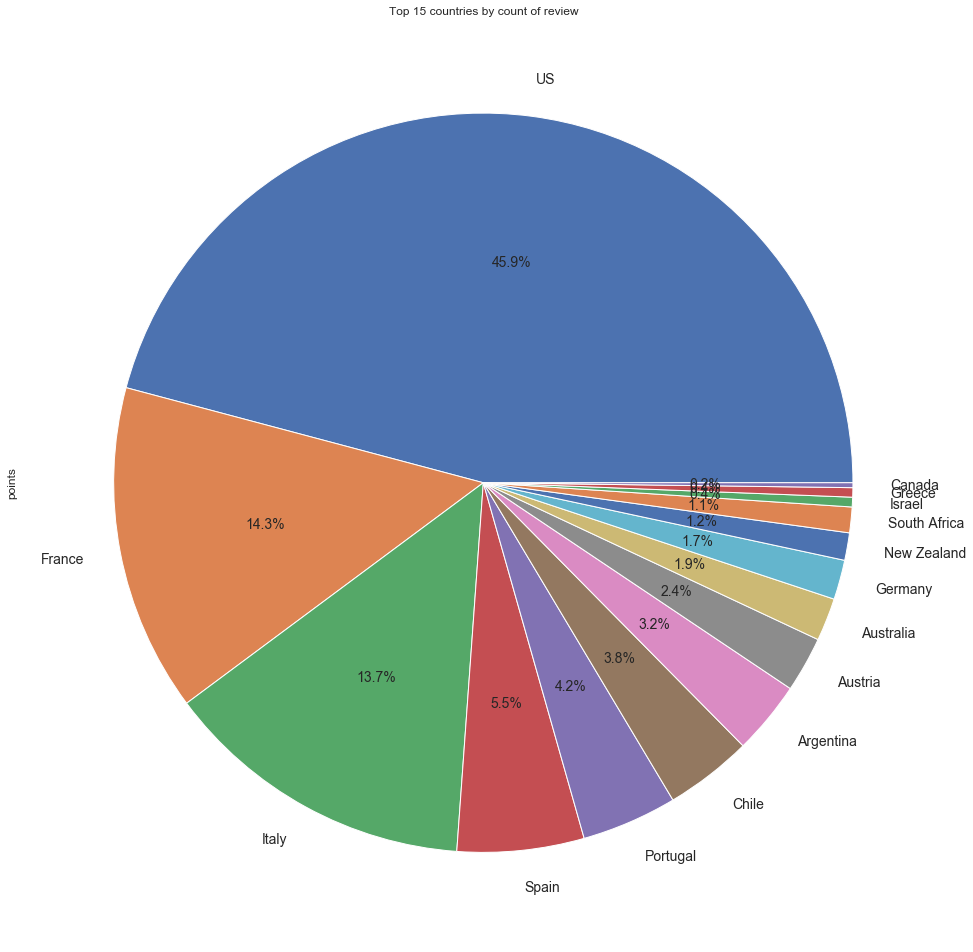

In [12]:
# See percentage of reviews by country for top 15
cwd_cntry = adj_cwd.groupby('country')
cwd_cntry_count = cwd_cntry['points'].count()

print(f'The total number of unique countries is {len(cwd_cntry_count.index)}')
print([cwd_cntry_count.sort_values(ascending=False).head(20)])

# Create pie plot of top 15 countries reviewed
t15_cwd_cntry_count = cwd_cntry_count.sort_values(ascending=False).head(15)

t15_cwd_cntry_count.plot.pie(figsize=(17,17),subplots=True,autopct='%1.1f%%',textprops={'fontsize': 14})
plt.title('Top 15 countries by count of review')

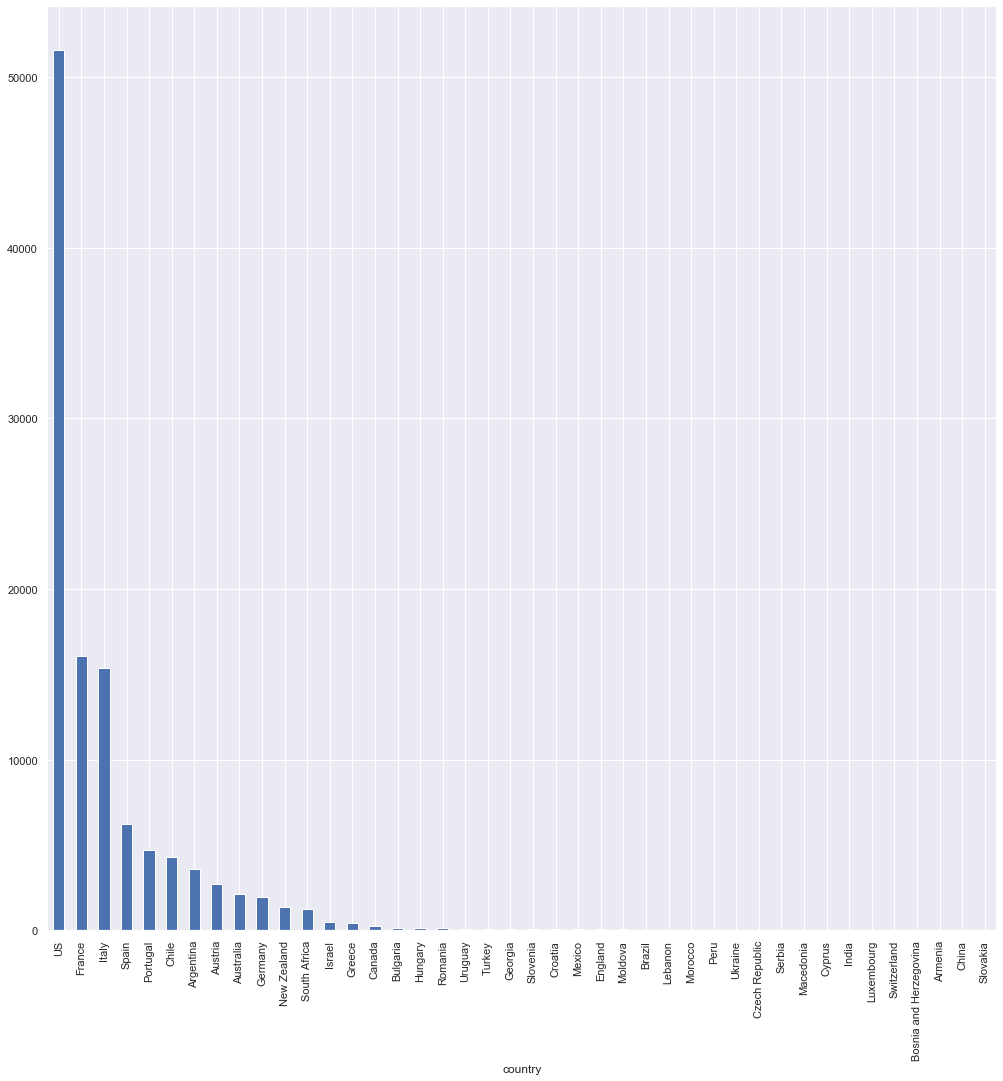

In [13]:
cwd_cntry_count.sort_values(ascending=False, inplace=True)
cwd_cntry_count.plot.bar(figsize=(17,17))

Text(0.5, 0, 'Country of Wine Origin')

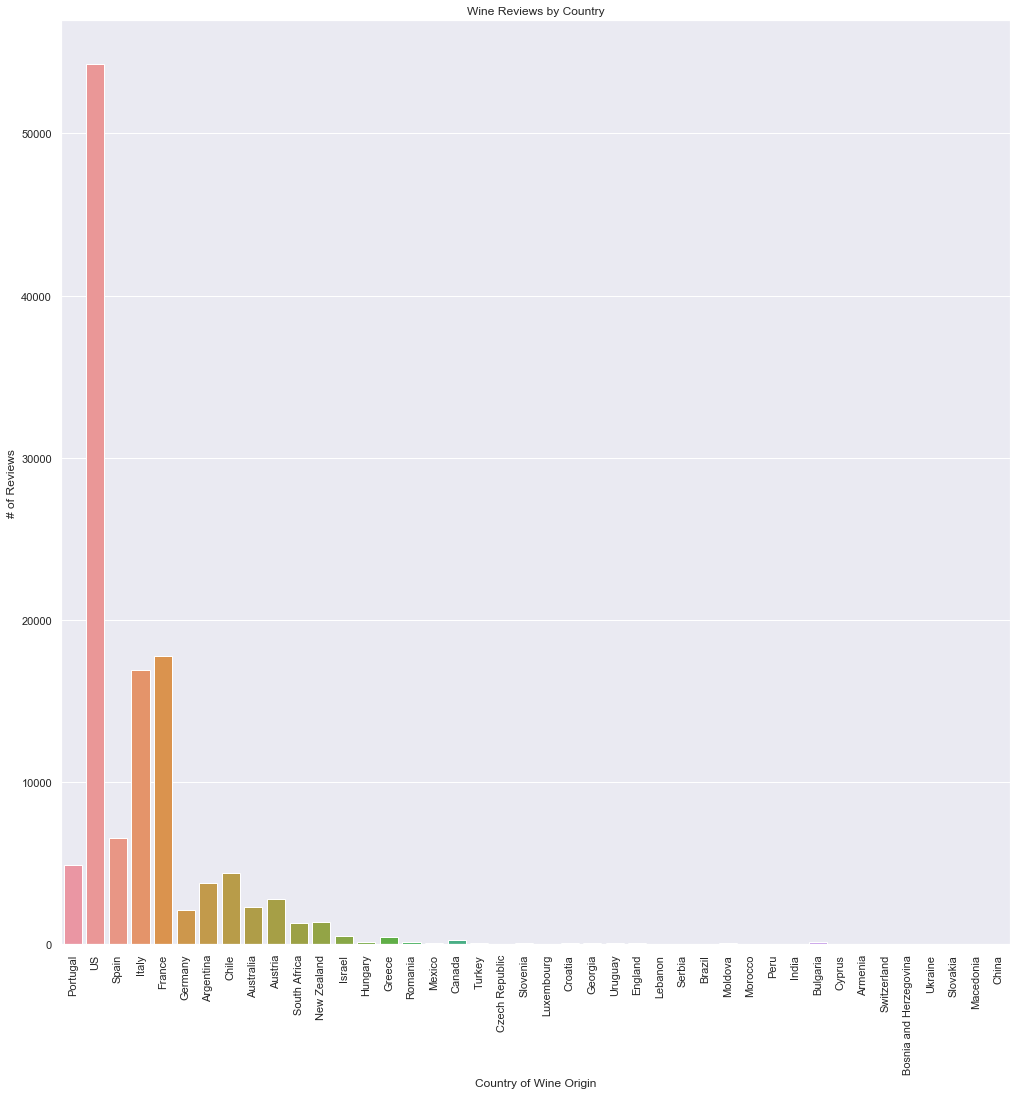

In [14]:
sns.countplot(x='country', data=CWD)
plt.xticks(rotation=90)
plt.title('Wine Reviews by Country')
plt.ylabel("# of Reviews")
plt.xlabel("Country of Wine Origin")

The total number of unique state/provinces is 421
[province
California            33876
Washington             8347
Oregon                 5141
Tuscany                4452
Bordeaux               3743
Northern Spain         3552
Mendoza Province       3085
New York               2670
Piedmont               2551
Burgundy               2344
Veneto                 2151
Alsace                 2096
Northeastern Italy     1948
Loire Valley           1580
Sicily & Sardinia      1520
Southwest France       1303
South Australia        1209
Provence               1129
Southern Italy         1096
Catalonia              1096
Name: points, dtype: int64]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EE6C16B8C8>],
      dtype=object)

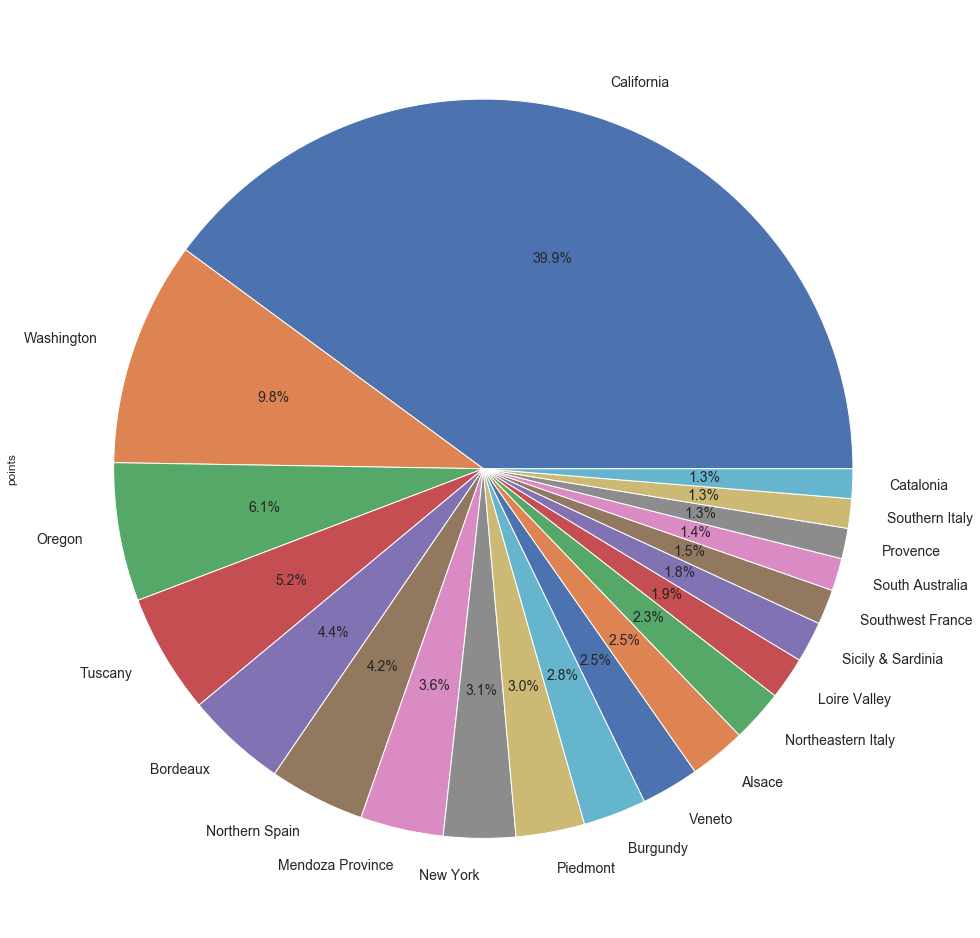

In [15]:
# See percentage of review by province/state for top 20
cwd_prov = adj_cwd.groupby('province')
cwd_prov_count = cwd_prov['points'].count()

print(f'The total number of unique state/provinces is {len(cwd_prov_count.index)}')
print([cwd_prov_count.sort_values(ascending=False).head(20)])

# Create pie plot of top 20 types by count of all wines
t20_cwd_prov_count = cwd_prov_count.sort_values(ascending=False).head(20)
t20_cwd_prov_count.plot.pie(figsize=(17,17),subplots=True,autopct='%1.1f%%',textprops={'fontsize': 14})

In [16]:
# Create df for CA wines
clean_ca_wines = adj_cwd.loc[adj_cwd['province'] == "California"]
clean_ca_wines.head()

,country,points,price,province,title,variety,winery,new_wine_metric
10,US,87,19.0,California,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,2.375
12,US,87,34.0,California,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini,4.250
14,US,87,12.0,California,Mirassou 2012 Chardonnay (Central Coast),Chardonnay,Mirassou,1.500
23,US,87,22.0,California,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi,2.750
25,US,87,69.0,California,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa,8.625


In [17]:
# create df for all wines
clean_gbl_wines = adj_cwd.copy()
clean_gbl_wines.head()

,country,points,price,province,title,variety,winery,new_wine_metric
1,Portugal,87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,1.875
2,US,87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,1.750
3,US,87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,1.625
4,US,87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,8.125
5,Spain,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,1.875


In [18]:
# create df for all wines excluding CA wines
clean_gbl_wines_noca = clean_gbl_wines.loc[clean_gbl_wines['province'] != "California"]
clean_gbl_wines_noca.head()

,country,points,price,province,title,variety,winery,new_wine_metric
1,Portugal,87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,1.875
2,US,87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,1.750
3,US,87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,1.625
4,US,87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,8.125
5,Spain,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,1.875


[variety
Pinot Noir                  6596
Chardonnay                  5116
Cabernet Sauvignon          4318
Zinfandel                   2627
Syrah                       1825
Sauvignon Blanc             1801
Red Blend                   1698
Merlot                      1359
Petite Sirah                 688
Bordeaux-style Red Blend     631
Sparkling Blend              519
Rosé                         508
Rhône-style Red Blend        487
Viognier                     432
Grenache                     372
White Blend                  358
Cabernet Franc               327
Pinot Grigio                 291
Riesling                     259
Sangiovese                   253
Name: title, dtype: int64]

There are 189 varietal types of wine reviewed from Califonrina

This is a breakdown of the top 20 by count of reviews


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EE6C226788>],
      dtype=object)

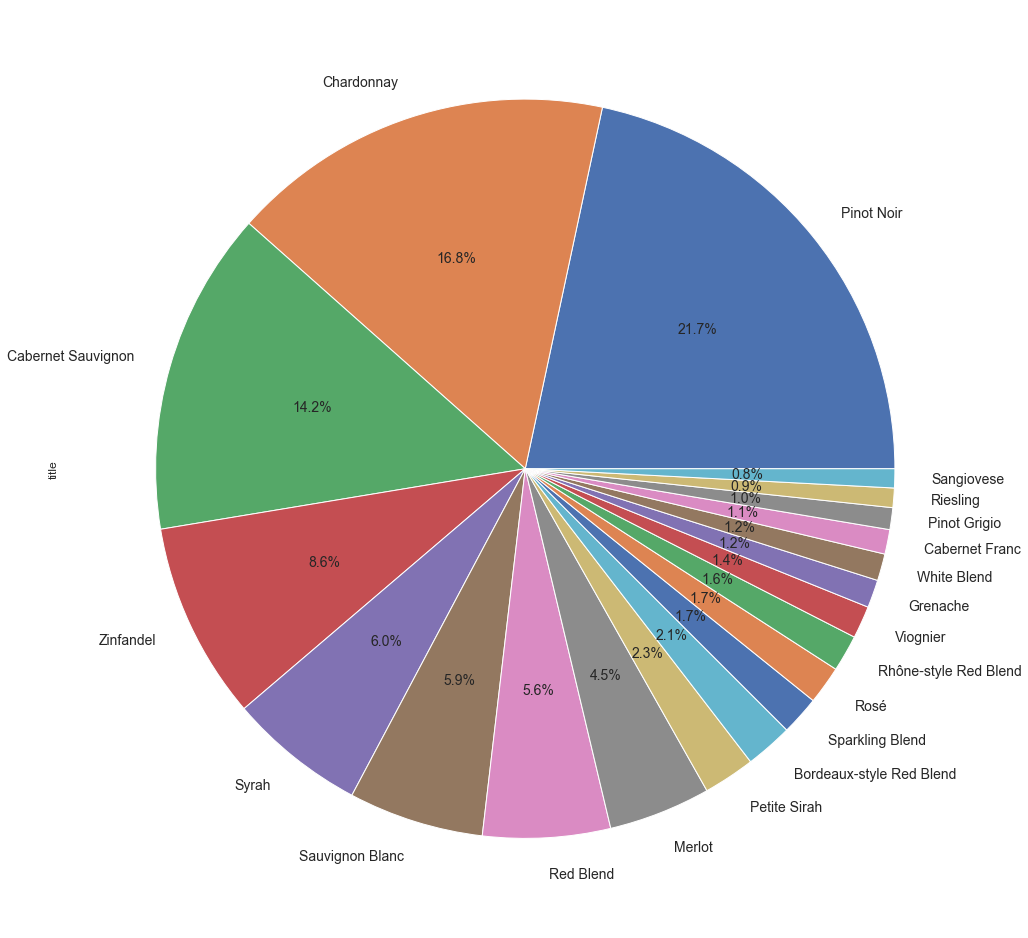

In [19]:
#ordered list of types and counts of CA wines
ca_varietal = clean_ca_wines.groupby('variety')
ca_type_count = ca_varietal['title'].count()
print([ca_type_count.sort_values(ascending=False).head(20)])
print()
print(f'There are {len(ca_type_count.index)} varietal types of wine reviewed from Califonrina')
print()
# Create pie plot of top 20 types by count of CA wines
print('This is a breakdown of the top 20 by count of reviews')
t20_ca_type_count = ca_type_count.sort_values(ascending=False).head(20)
t20_ca_type_count.plot.pie(figsize=(17,17),subplots=True,autopct='%1.1f%%',textprops={'fontsize': 14})

[variety
Pinot Noir                  11832
Chardonnay                  10591
Red Blend                    7931
Cabernet Sauvignon           7885
Riesling                     4778
Sauvignon Blanc              4772
Bordeaux-style Red Blend     4765
Syrah                        3874
Rosé                         3250
Merlot                       2975
Zinfandel                    2702
Malbec                       2470
White Blend                  2135
Portuguese Red               2124
Sangiovese                   2081
Sparkling Blend              1978
Nebbiolo                     1793
Tempranillo                  1691
Pinot Gris                   1368
Rhône-style Red Blend        1356
Name: title, dtype: int64]

There are 686 varietal types of wine reviewed from All over the world

This is a breakdown of the top 20 by count of reviews


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EE6DE58948>],
      dtype=object)

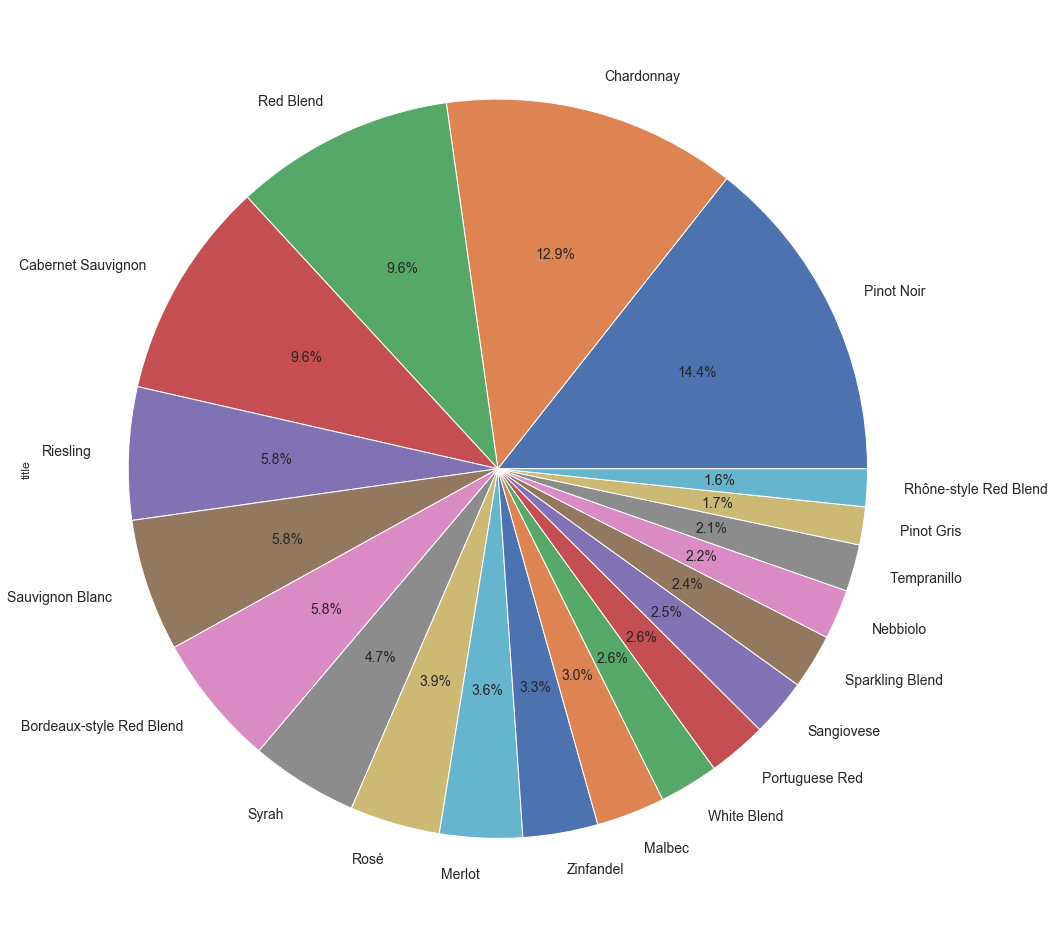

In [20]:
#ordered list of types and counts of Global wines including CA
gbl_varietal = clean_gbl_wines.groupby('variety')
gbl_type_count = gbl_varietal['title'].count()
print([gbl_type_count.sort_values(ascending=False).head(20)])
print()
print(f'There are {len(gbl_type_count.index)} varietal types of wine reviewed from All over the world')
print()
# Create pie plot of top 20 types by count of Global wines including CA
print('This is a breakdown of the top 20 by count of reviews')
t20_gbl_type_count = gbl_type_count.sort_values(ascending=False).head(20)
t20_gbl_type_count.plot.pie(figsize=(17,17),subplots=True,autopct='%1.1f%%',textprops={'fontsize': 14})

[variety
Red Blend                   6233
Chardonnay                  5475
Pinot Noir                  5236
Riesling                    4519
Bordeaux-style Red Blend    4134
Cabernet Sauvignon          3567
Sauvignon Blanc             2971
Rosé                        2742
Malbec                      2278
Portuguese Red              2124
Syrah                       2049
Sangiovese                  1828
White Blend                 1777
Nebbiolo                    1762
Merlot                      1616
Tempranillo                 1555
Sparkling Blend             1459
Pinot Gris                  1176
Grüner Veltliner            1106
Portuguese White             985
Name: title, dtype: int64]

There are 666 varietal types of wine reviewed from every else besides Califonrina

This is a breakdown of the top 20 by count of reviews


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EE703B8808>],
      dtype=object)

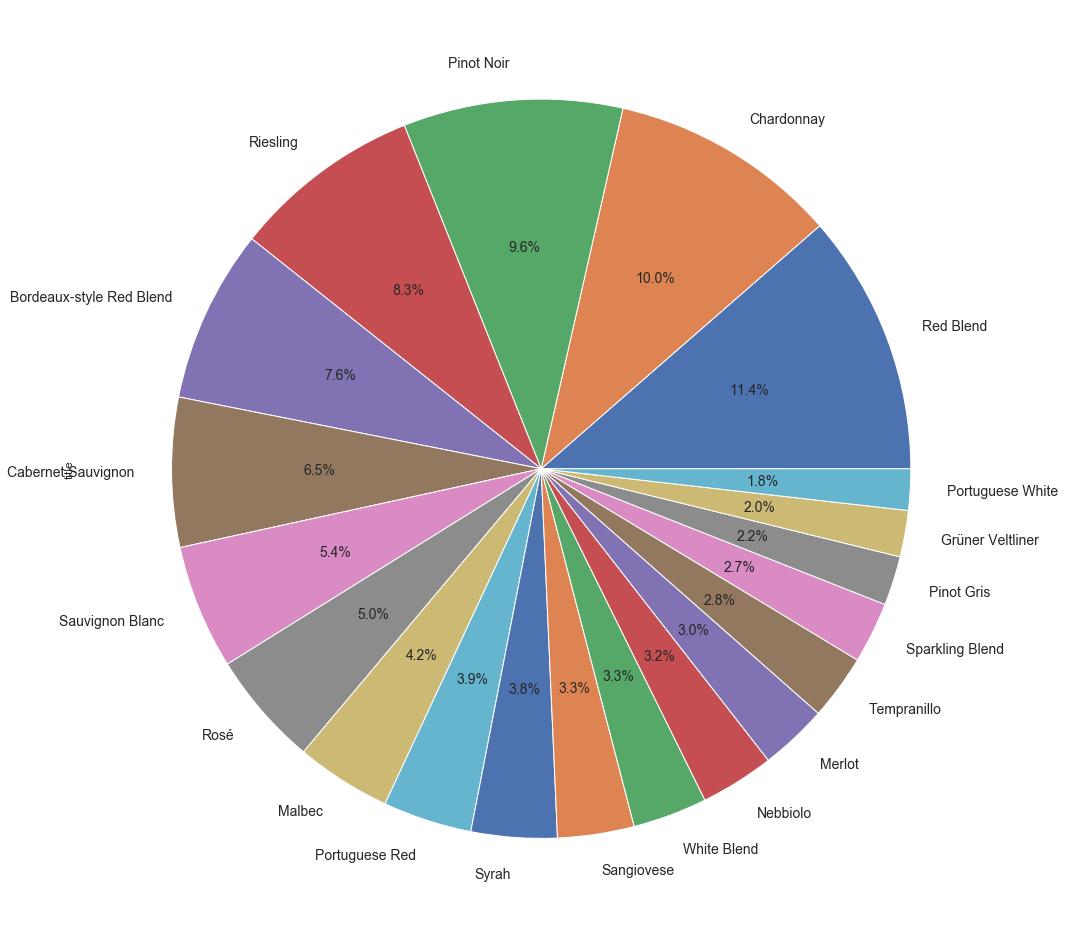

In [21]:
#ordered list of types and counts of Global wines without CA
noca_gbl_varietal = clean_gbl_wines_noca.groupby('variety')
noca_gbl_type_count = noca_gbl_varietal['title'].count()
print([noca_gbl_type_count.sort_values(ascending=False).head(20)])
print()
print(f'There are {len(noca_gbl_type_count.index)} varietal types of wine reviewed from every else besides Califonrina')
print()
# Create pie plot of top 20 types by count of Global wines without CA
print('This is a breakdown of the top 20 by count of reviews')
t20_noca_gbl_type_count = noca_gbl_type_count.sort_values(ascending=False).head(20)
t20_noca_gbl_type_count.plot.pie(figsize=(17,17),subplots=True,autopct='%1.1f%%',textprops={'fontsize': 14})

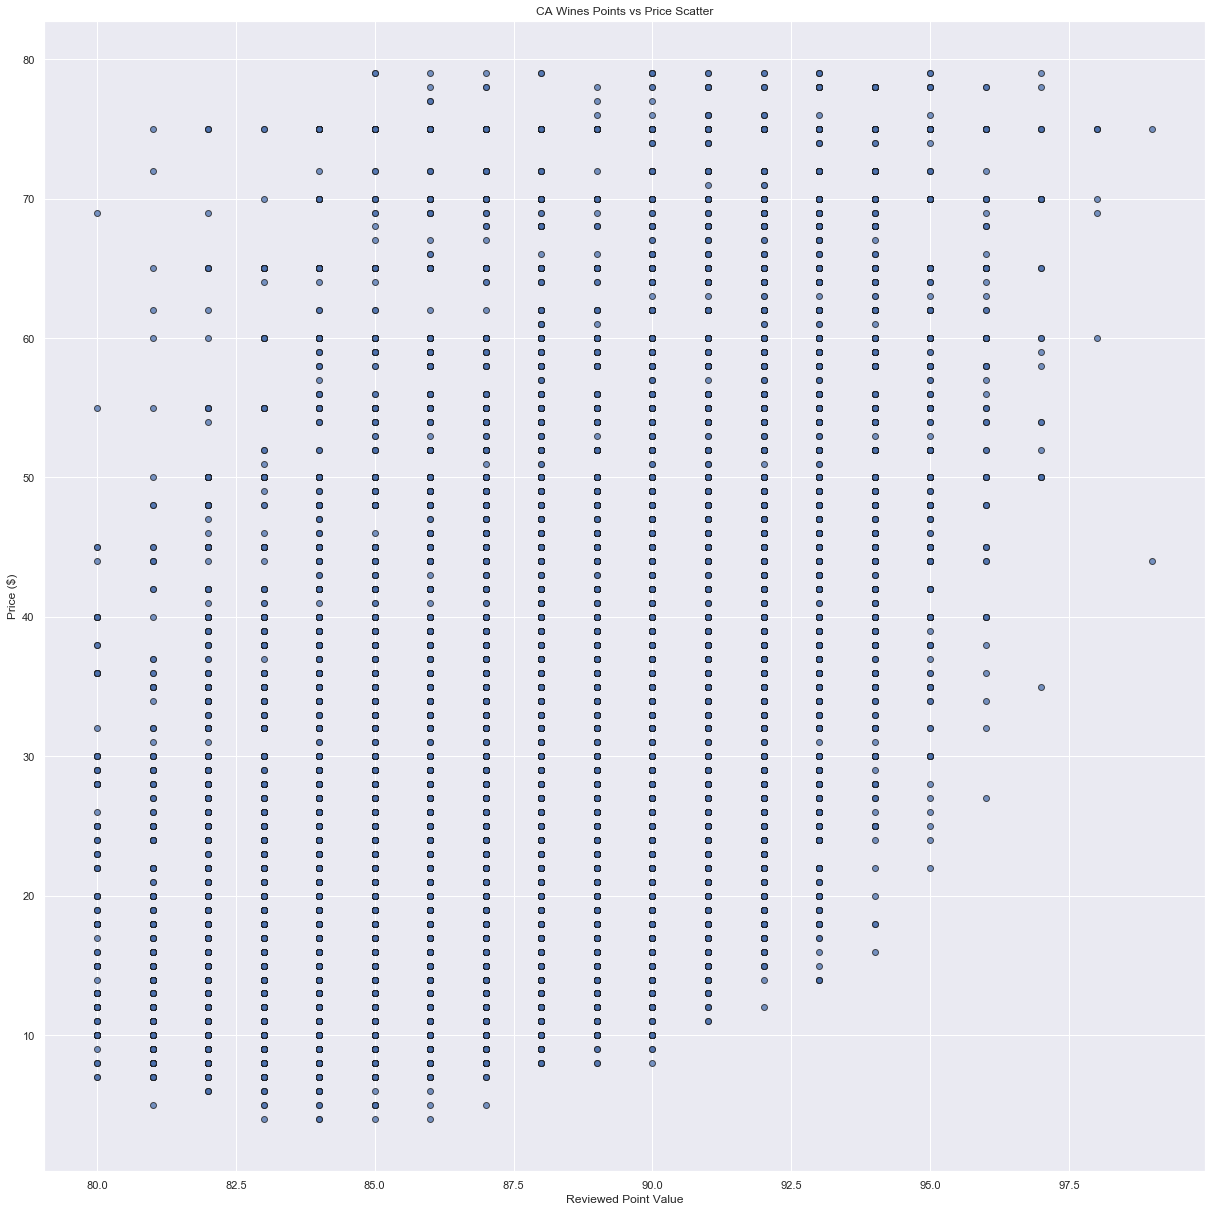

In [22]:
# points vs price
plt.figure(figsize=(17, 17))
plt.scatter(clean_ca_wines['points'], clean_ca_wines['price'], alpha=.75, edgecolors="k")
# x,y required , alpha sets opacity, edgecolors help datapoint stand out https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html
plt.title(f"CA Wines Points vs Price Scatter")
plt.ylabel("Price ($)")
plt.xlabel("Reviewed Point Value")
plt.grid(True) 
plt.tight_layout() 
# tight_layout. This module provides routines to adjust subplot params so that subplots are nicely fit in the figure. https://matplotlib.org/api/tight_layout_api.html
plt.show()

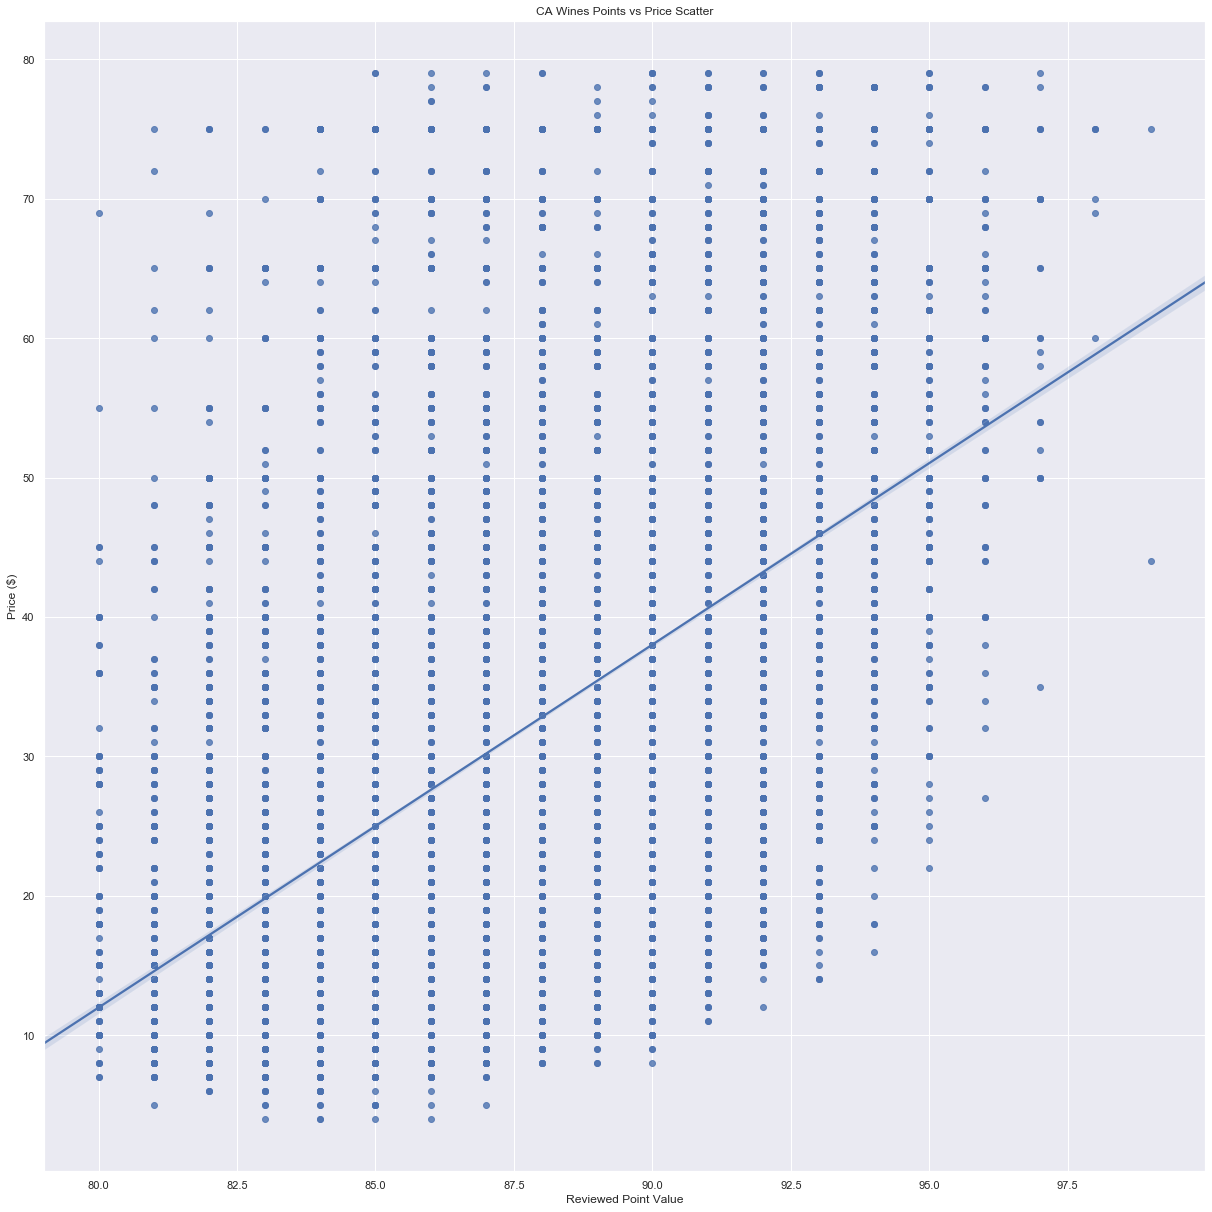

In [23]:
#seaborn scatterplot
plt.figure(figsize=(17, 17))
sns.regplot(x='points', y='price', data=clean_ca_wines)
plt.title(f"CA Wines Points vs Price Scatter")
plt.ylabel("Price ($)")
plt.xlabel("Reviewed Point Value")
plt.grid(True) 
plt.tight_layout() 
plt.show()

The correlation coefficient between Review Points and Price is 0.51 for CA Wines


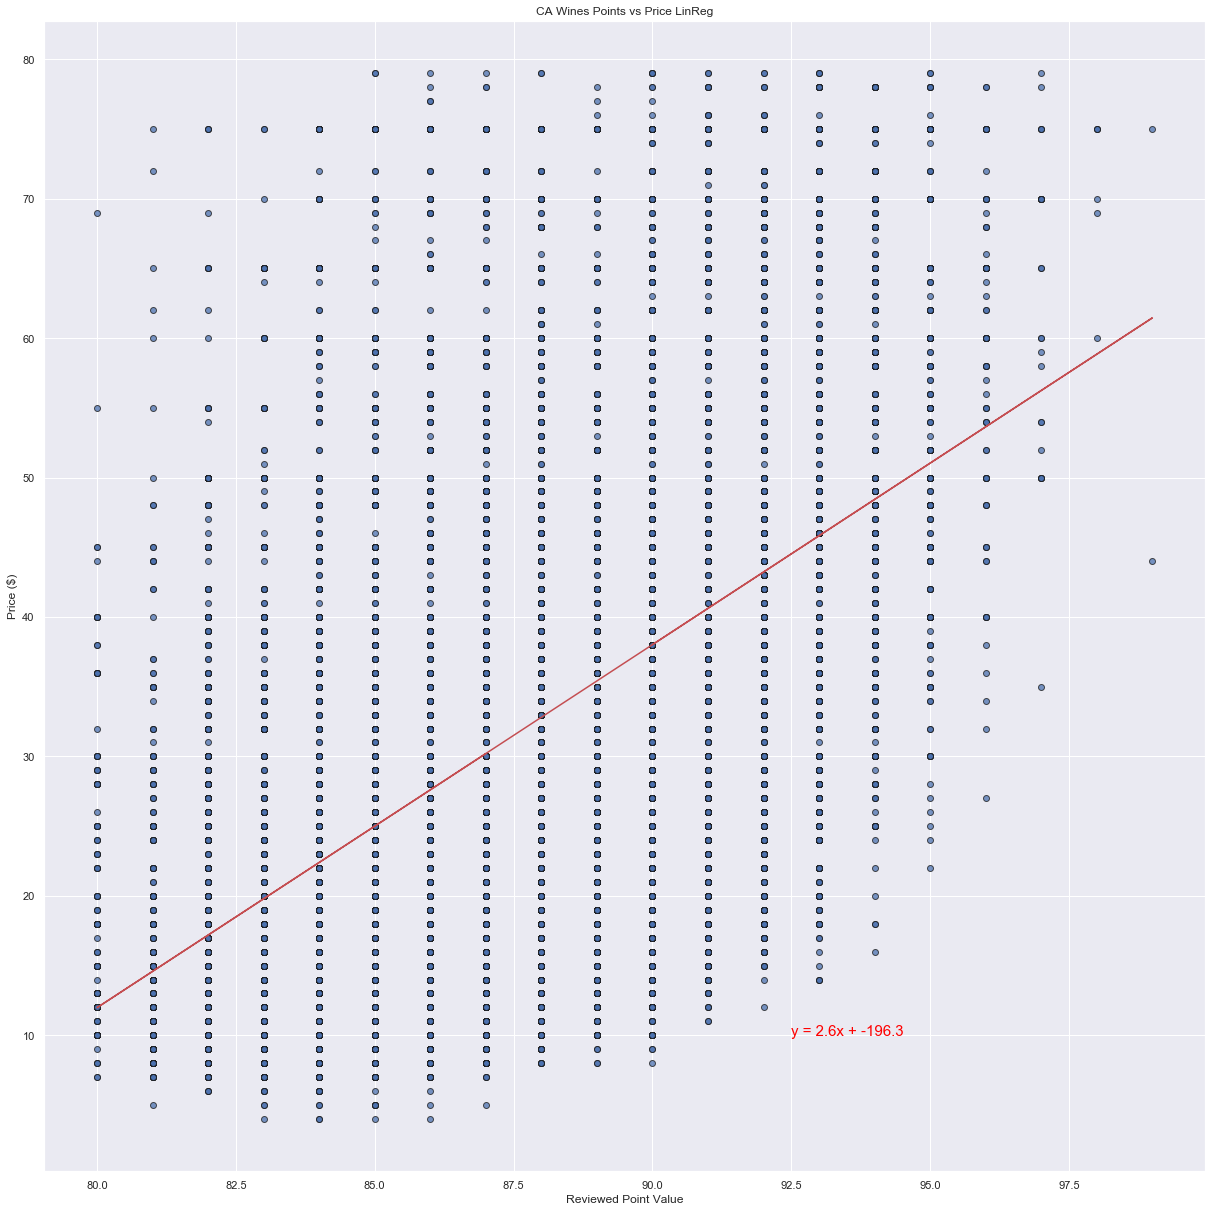

In [24]:
x_values = clean_ca_wines['points'].astype(float)
y_values = clean_ca_wines['price'].astype(float)

# Calculate Pearson r value
print(f"The correlation coefficient between Review Points and Price is {round(stats.pearsonr(x_values,y_values)[0],2)} for CA Wines")

# Calculate line for plot
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Create plot and labels

plt.figure(figsize=(17, 17))
plt.title(f"CA Wines Points vs Price LinReg")
plt.scatter(x_values,y_values, alpha=.75, edgecolors="k") 
# x,y required , alpha sets opacity, edgecolors help datapoint stand out https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(92.5,10),fontsize=15,color="red")
plt.ylabel("Price ($)")
plt.xlabel("Reviewed Point Value")
plt.grid(True) 
plt.tight_layout() 
plt.show()

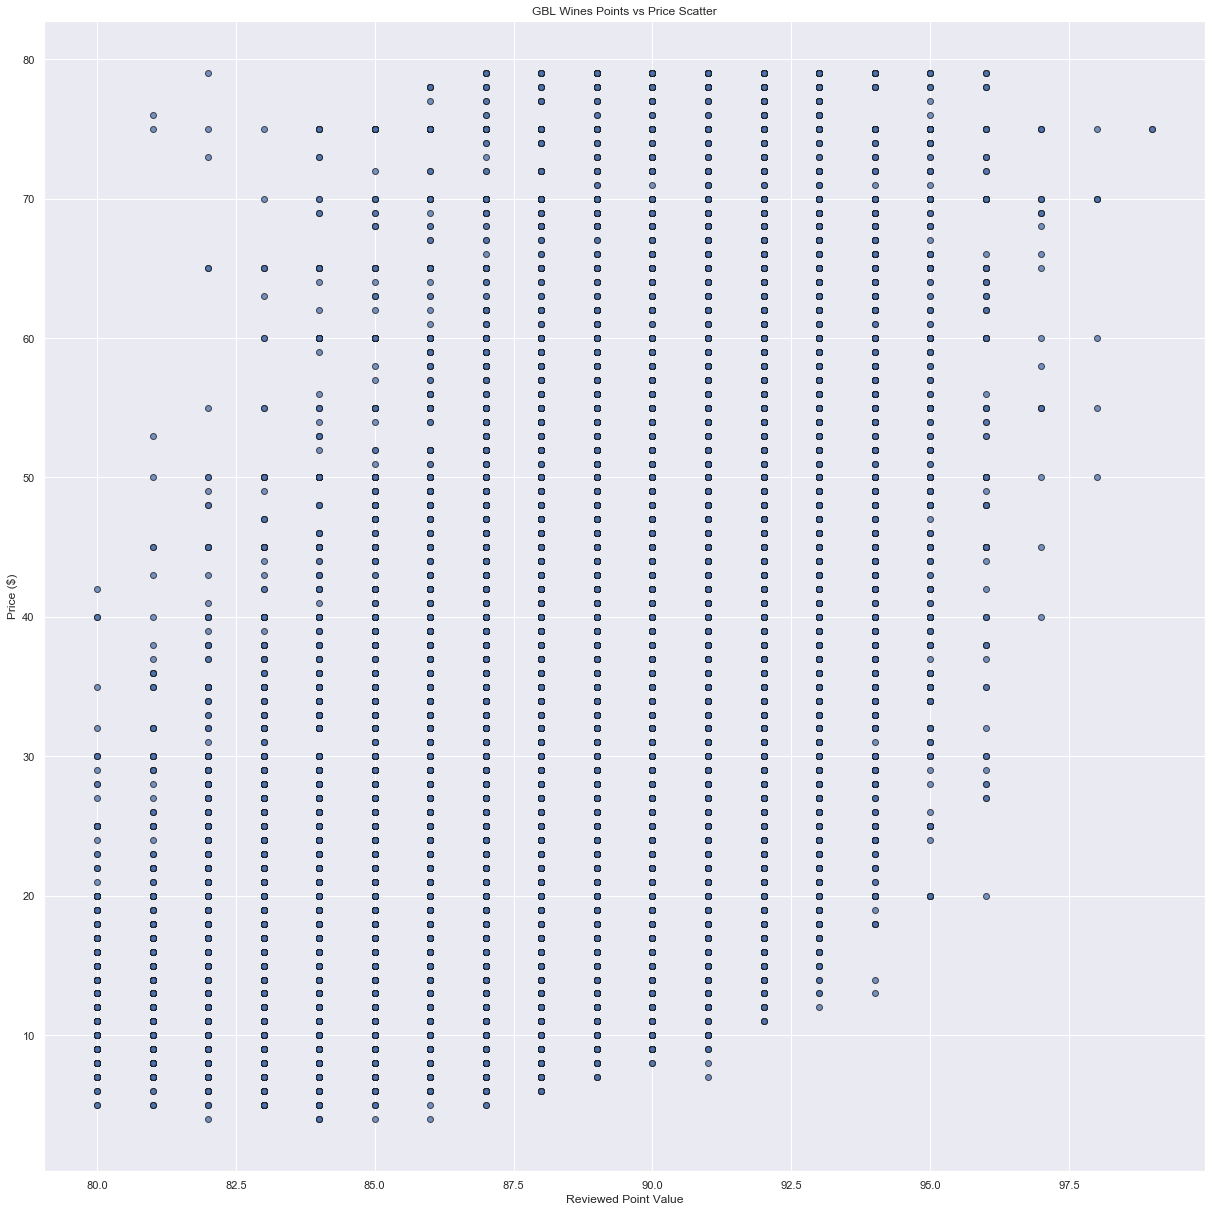

In [25]:
# GBL no CA points vs price
plt.figure(figsize=(17, 17))
plt.scatter(clean_gbl_wines_noca['points'], clean_gbl_wines_noca['price'], alpha=.75, edgecolors="k")
# x,y required , alpha sets opacity, edgecolors help datapoint stand out https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html
plt.title(f"GBL Wines Points vs Price Scatter")
plt.ylabel("Price ($)")
plt.xlabel("Reviewed Point Value")
plt.grid(True) 
plt.tight_layout() 
# tight_layout. This module provides routines to adjust subplot params so that subplots are nicely fit in the figure. https://matplotlib.org/api/tight_layout_api.html
plt.show()

The correlation coefficient between Review Points and Price is 0.56 for GBL Wines not from CA


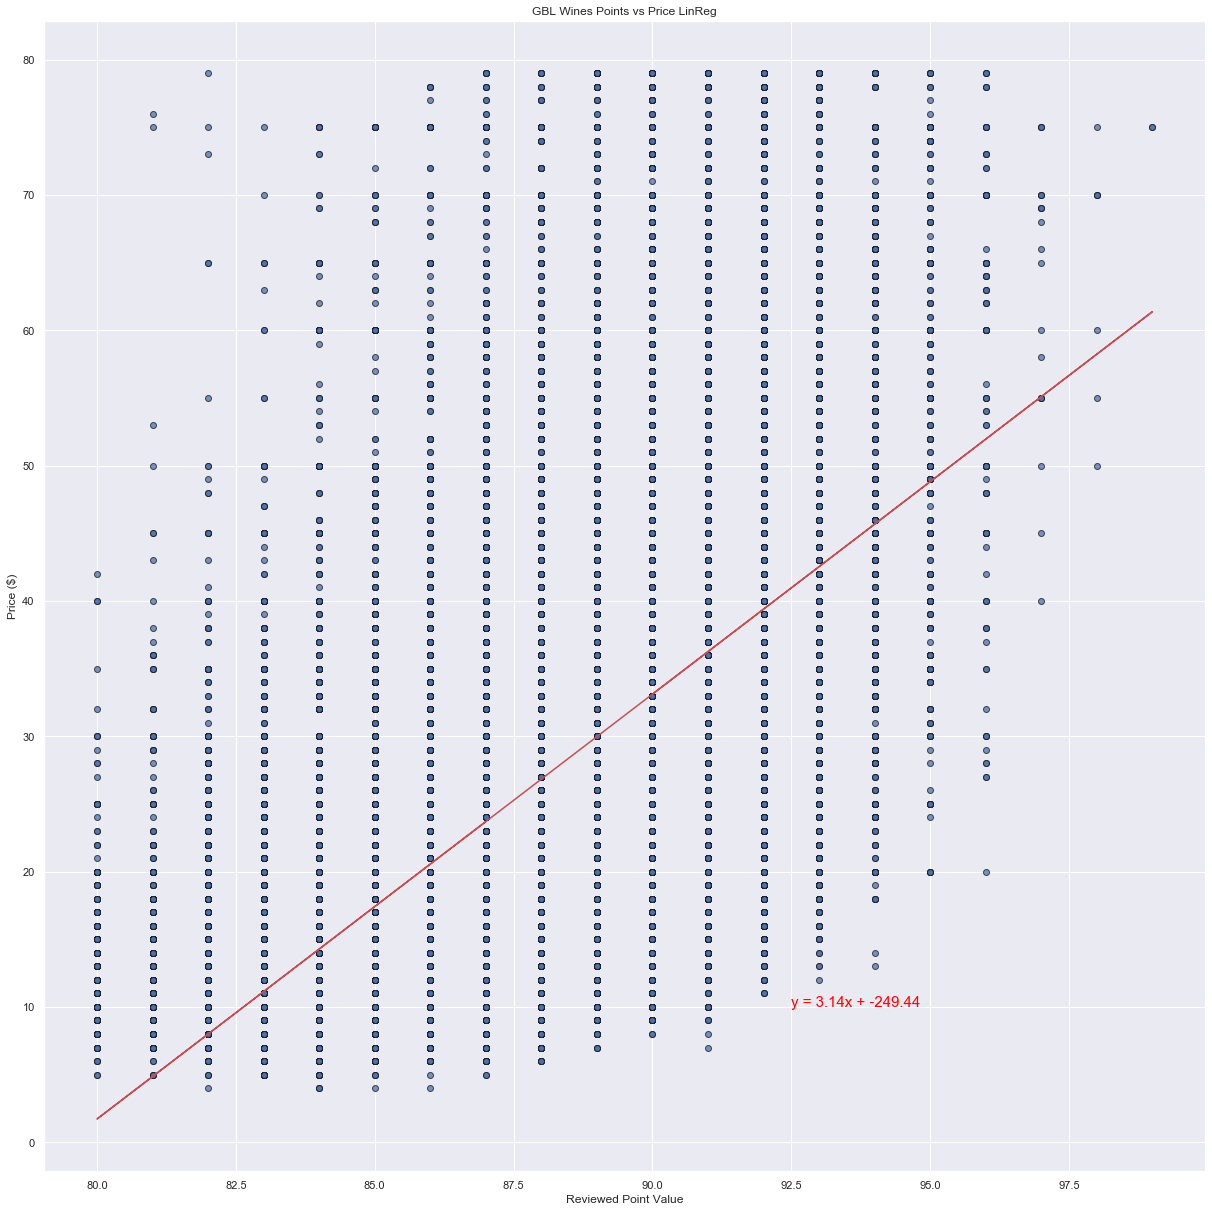

In [26]:
x_values = clean_gbl_wines_noca['points'].astype(float)
y_values = clean_gbl_wines_noca['price'].astype(float)

# Calculate Pearson r value
print(f"The correlation coefficient between Review Points and Price is {round(stats.pearsonr(x_values,y_values)[0],2)} for GBL Wines not from CA")

# Calculate line for plot
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Create plot and labels

plt.figure(figsize=(17, 17))
plt.title(f"GBL Wines Points vs Price LinReg")
plt.scatter(x_values,y_values, alpha=.75, edgecolors="k") 
# x,y required , alpha sets opacity, edgecolors help datapoint stand out https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(92.5,10),fontsize=15,color="red")
plt.ylabel("Price ($)")
plt.xlabel("Reviewed Point Value")
plt.grid(True) 
plt.tight_layout() 
plt.show()

In [27]:
good_value_wines = clean_gbl_wines.loc[(clean_gbl_wines['price'] <= 20) & (clean_gbl_wines['points'] >= 94)]
good_value_wines

,country,points,price,province,title,variety,winery,new_wine_metric
5011,US,95,20.0,Washington,Dunham 2010 Lewis Estate Vineyard Riesling (Co...,Riesling,Dunham,1.250000
6267,US,94,18.0,Washington,Stottle 2011 Lucille Late Harvest Viognier (Ya...,Viognier,Stottle,1.200000
15196,France,95,20.0,Southwest France,Alain Brumont 2010 Château Bouscassé Red (Madi...,Red Blend,Alain Brumont,1.250000
17294,US,94,20.0,Washington,Brian Carter Cellars 2009 Opulento Dessert Win...,Port,Brian Carter Cellars,1.333333
17983,France,94,20.0,Provence,Château Vignelaure 2016 Rosé (Coteaux d'Aix-en...,Rosé,Château Vignelaure,1.333333
19136,Spain,94,14.0,Andalucia,Osborne NV Pedro Ximenez 1827 Sweet Sherry She...,Sherry,Osborne,0.933333
20364,France,94,20.0,Alsace,Domaine Marcel Deiss 2011 White (Alsace),White Blend,Domaine Marcel Deiss,1.333333
23974,Portugal,94,13.0,Douro,Quinta dos Murças 2011 Assobio Red (Douro),Portuguese Red,Quinta dos Murças,0.866667
26432,Italy,94,20.0,Sicily & Sardinia,Le Casematte 2014 Peloro Red (Terre Siciliane),Red Blend,Le Casematte,1.333333
28575,US,94,20.0,California,Alma Rosa 2006 Chardonnay (Santa Barbara County),Chardonnay,Alma Rosa,1.333333


In [28]:
good_value_wines_prov = good_value_wines.groupby('province')
good_value_wines_prov['winery'].count()

province
Alentejano            1
Alsace                1
Andalucia             1
Beaujolais            1
California            4
Douro                 1
Kamptal               1
Kremstal              1
Oregon                2
Provence              1
Sicily & Sardinia     1
South Australia       1
Southwest France      4
Veneto                1
Washington           13
Name: winery, dtype: int64

In [29]:
# top 10 province by avg price
# See percentage of review by province/state for top 20
### Using cwd_prov = CWD.groupby('province') from above

cwd_prov_mean = cwd_prov['price'].mean().round(2)

print([cwd_prov_mean])
print()
print('The top 10 most expensive to least expensive provinces/states reviewed were:')
print([cwd_prov_mean.sort_values(ascending=False).head(10)])
print()
print(f'There were {len(cwd_prov_mean.index)} provinces/states reviewed.')

[province
Achaia                       23.00
Aconcagua Costa              20.31
Aconcagua Valley             22.75
Aegean                       29.29
Agioritikos                  24.00
                             ...  
Zenata                       16.84
Österreichischer Perlwein    16.75
Österreichischer Sekt        27.98
Štajerska                    17.18
Župa                         27.75
Name: price, Length: 421, dtype: float64]

The top 10 most expensive to least expensive provinces/states reviewed were:
[province
Haut-Judeé                   66.25
Middle and South Dalmatia    65.00
Südburgenland                57.00
Waitaki Valley               55.00
Champagne                    53.18
Jerusalem Hills              52.50
England                      48.67
Tulbagh                      48.25
Golan Heights                46.67
Ahr                          46.00
Name: price, dtype: float64]

There were 421 provinces/states reviewed.


In [30]:
# top 20 most reviewed wineries by avg point - count of reviews and then avg reviews
winery_groups = clean_gbl_wines.groupby('winery')

print(f'The number of unique wineries reviewed is {len(winery_groups)}')
print()
winery_groups_count = winery_groups['points'].count()
print('The most frequently reviewed wineries are:')
print([winery_groups_count.sort_values(ascending=False).head(20)])
print()
print()
winery_groups_avg_points = winery_groups['points'].mean()
print([winery_groups_avg_points.sort_values(ascending=False).head(20)])
print()
print()
winery_groups_avg_price = winery_groups['price'].mean().round(2)
print([winery_groups_avg_price.sort_values(ascending=False).head(20)])
print()
print()
winery_merged_data = pd.merge(winery_groups_count,winery_groups_avg_points, on="winery", how="inner")
winery_merged_data = pd.merge(winery_merged_data,winery_groups_avg_price, on="winery", how="inner")
winery_merged_data.columns = ['Review Count','Avg Review','Avg Price']
print([winery_merged_data.sort_values(by=['Review Count'],ascending=False).head(50)])

The number of unique wineries reviewed is 15532

The most frequently reviewed wineries are:
[winery
Testarossa               211
DFJ Vinhos               209
Wines & Winemakers       209
Chateau Ste. Michelle    193
Williams Selyem          189
Columbia Crest           158
Concha y Toro            149
Siduri                   126
Kendall-Jackson          125
Gary Farrell             125
Georges Duboeuf          120
Undurraga                111
Trapiche                 111
Fess Parker              108
Lynmar                   108
Robert Mondavi           105
Montes                   104
Santa Ema                104
Maryhill                 102
Foxen                    102
Name: points, dtype: int64]


[winery
Lewis                          96.000000
D'Alfonso-Curran               96.000000
Scaggs Vineyard                95.000000
Schloss Schönborn              95.000000
Château Pichon Longueville     95.000000
Copain Wines                   95.000000
Aleksander                     95.00

In [31]:
cal_wine_count = clean_ca_wines['price'].count()
noncal_wine_count = clean_gbl_wines_noca['price'].count()


# look at IQR for price
cal_price_iqr = clean_ca_wines['price']
cal_quartiles = round(cal_price_iqr.quantile([.25,.5,.75]),2)
cal_lowerq = round(cal_quartiles[0.25],2)
cal_upperq = round(cal_quartiles[0.75],2)
cal_iqr = round(cal_upperq-cal_lowerq,2)

print('California IQR price Data:')
print(f"The lower quartile of price for Californian Wines is : {cal_lowerq}")
print(f"The upper quartile of price for Californian Wines is: {cal_upperq}")
print(f"The interquartile range of pricee for Californian Wines is: {cal_iqr}")
print(f"The the median of price for Californian Wines is: {cal_quartiles[0.5]} ")

cal_lower_bound = round(cal_lowerq - (1.5*cal_iqr),2)
cal_upper_bound = round(cal_upperq + (1.5*cal_iqr),2)

# print(f"Values below {cal_lower_bound} could be outliers.")

print(f"Values above {cal_upper_bound} could be outliers.")
#cal_lwr_otlr_count = clean_ca_wines.loc[clean_ca_wines['price'] <= {cal_lower_bound}]
cal_upr_otlr_count = clean_ca_wines['price'][clean_ca_wines['price'] >= 87].count()
cal_otlr_pct = (cal_upr_otlr_count/cal_wine_count)*100
print(f'Of the {cal_wine_count} Californian wines, There are {cal_upr_otlr_count} above the upper bounds or {cal_otlr_pct.round(2)}%')

noncal_price_iqr = clean_gbl_wines_noca['price']
noncal_quartiles = round(noncal_price_iqr.quantile([.25,.5,.75]),2)
noncal_lowerq = round(noncal_quartiles[0.25],2)
noncal_upperq = round(noncal_quartiles[0.75],2)
noncal_iqr = round(noncal_upperq-noncal_lowerq,2)

print()
print('Non Californian IQR price Data:')
print(f"The lower quartile of price for non Californian Wines is : {noncal_lowerq}")
print(f"The upper quartile of price for non Californian Wines is: {noncal_upperq}")
print(f"The interquartile range of pricee for non Californian Wines is: {noncal_iqr}")
print(f"The the median of price for non Californian Wines is: {noncal_quartiles[0.5]} ")

noncal_lower_bound = round(noncal_lowerq - (1.5*cal_iqr),2)
noncal_upper_bound = round(noncal_upperq + (1.5*cal_iqr),2)

# print(f"Values below {noncal_lower_bound} could be outliers.")

print(f"Values above {noncal_upper_bound} could be outliers.")

noncal_upr_otlr_count = clean_gbl_wines_noca['price'][clean_gbl_wines_noca['price'] >= 79].count()
noncal_otlr_pct = (noncal_upr_otlr_count/noncal_wine_count)*100
print(f'Of the {noncal_wine_count} Californian wines, There are {noncal_upr_otlr_count} NonCalifornian wines above the upper bounds or {noncal_otlr_pct.round(2)}%')

California IQR price Data:
The lower quartile of price for Californian Wines is : 20.0
The upper quartile of price for Californian Wines is: 45.0
The interquartile range of pricee for Californian Wines is: 25.0
The the median of price for Californian Wines is: 30.0 
Values above 82.5 could be outliers.
Of the 33876 Californian wines, There are 0 above the upper bounds or 0.0%

Non Californian IQR price Data:
The lower quartile of price for non Californian Wines is : 15.0
The upper quartile of price for non Californian Wines is: 35.0
The interquartile range of pricee for non Californian Wines is: 20.0
The the median of price for non Californian Wines is: 22.0 
Values above 72.5 could be outliers.
Of the 79798 Californian wines, There are 108 NonCalifornian wines above the upper bounds or 0.14%


C:\Users\Armstrong\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Armstrong\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


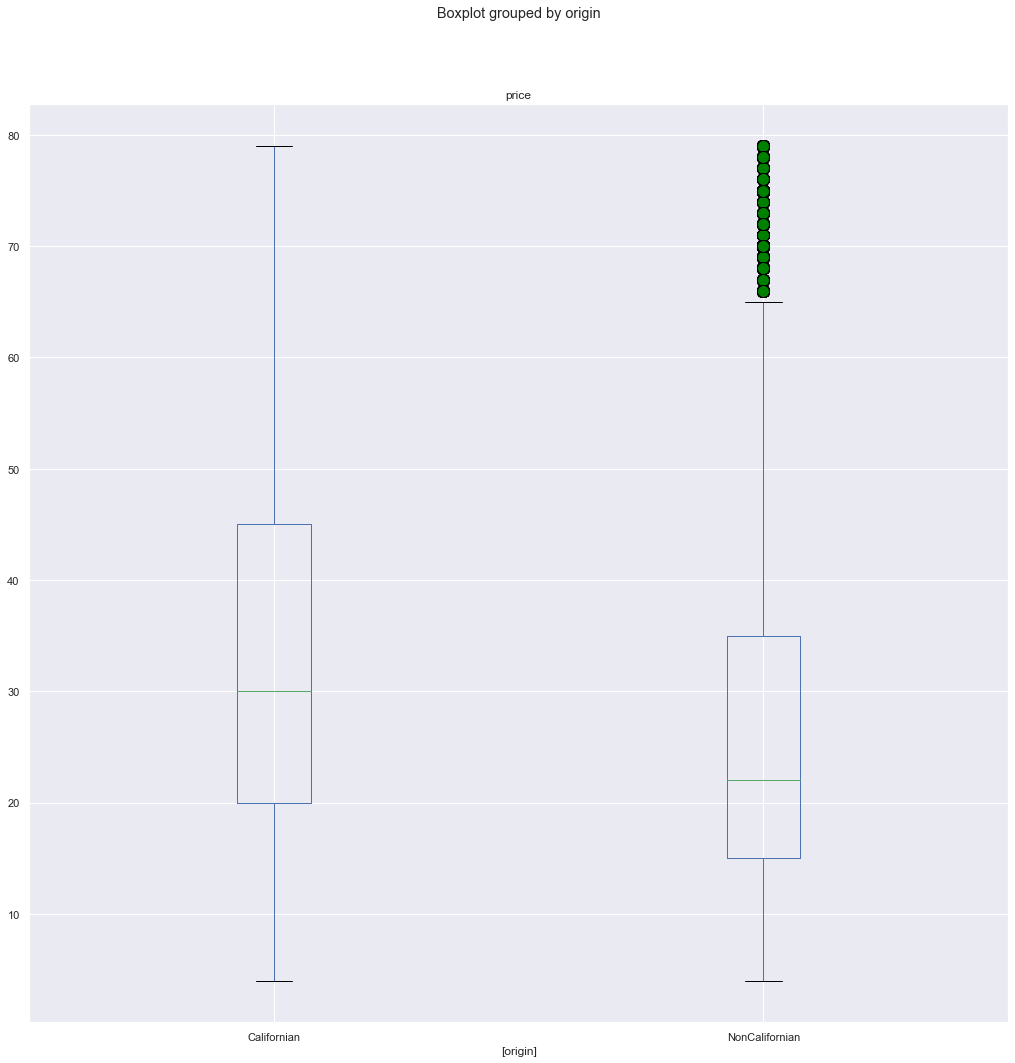

In [32]:
#Eliminate outliers

bw_plt_data = []
bw_plt_data = clean_gbl_wines[['price','province']]
bw_plt_data.loc[bw_plt_data['province'] == 'California', 'origin'] = 'Californian'
bw_plt_data.loc[bw_plt_data['province'] != 'California', 'origin'] = 'NonCalifornian'
bw_plt_data

flierprops = dict(marker='o', markerfacecolor='green', markersize=12,
                  linestyle='none')

bw_plt_data.boxplot(by="origin", flierprops=flierprops, figsize=(17,17))
#plt.set_title('Wine Origin Price')
#plt.set_ylabel('Price in USD')
plt.show()

In [33]:
# Run a ttest on points

# Isolate the data to compare
cal_reviews = adj_cwd.loc[adj_cwd['province'] == 'California']['points']
noncal_reviews = adj_cwd.loc[adj_cwd['province'] != 'California']['points']

# Note: Setting equal_var=False performs Welch's t-test which does 
# not assume equal population variance
stats.ttest_ind(cal_reviews, noncal_reviews, equal_var=False)

Ttest_indResult(statistic=16.733599099167783, pvalue=1.0528918924684553e-62)

In [34]:
# Run a ttest on price

# Isolate the data to compare
cal_price_reviews = adj_cwd.loc[adj_cwd['province'] == 'California']['price']
noncal_price_reviews = adj_cwd.loc[adj_cwd['province'] != 'California']['price']

# Note: Setting equal_var=False performs Welch's t-test which does 
# not assume equal population variance
stats.ttest_ind(cal_price_reviews, noncal_price_reviews, equal_var=False)

Ttest_indResult(statistic=65.02103152389508, pvalue=0.0)

In [35]:
# ANOVA Test

# Perform the ANOVA
stats.f_oneway(cal_reviews, noncal_reviews)

F_onewayResult(statistic=310.85172173388037, pvalue=1.763610367932344e-69)

In [36]:
# CHI Squared Analysis

chi_cal_nwm = adj_cwd.loc[adj_cwd['province'] == 'California']['new_wine_metric'].mean()
chi_noncal_nwm = adj_cwd.loc[adj_cwd['province'] != 'California']['new_wine_metric'].mean()

observed = pd.Series([[chi_cal_nwm][0],[chi_noncal_nwm][0]], index=["California", "NonCalifornia"])

wine_chi = pd.DataFrame([observed]).T

# Create a data frame
wine_chi[1] = CWD['new_wine_metric'].mean()

# Rename columns
wine_chi.columns = ["observed", "expected"]

# View the data frame
wine_chi

,observed,expected
California,3.861562,3.705705
NonCalifornia,3.046300,3.705705


In [37]:
# The degree of freedom is either California or Non California so DoF (2-1 = 1)
# With a p-value of 0.05, the confidence level is 1.00-0.05 = 0.95.

critical_value = stats.chi2.ppf(q = 0.95, df = 1)

# The critical value
print(critical_value)

# Run the chi square test with stats.chisquare()
stats.chisquare(wine_chi['observed'], wine_chi['expected'])

3.841458820694124


Power_divergenceResult(statistic=0.12389153487949717, pvalue=0.7248515416395649)